<a href="https://colab.research.google.com/github/Twilightin/Time/blob/main/Time_Traveller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import pkg

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns; sns.set(style='darkgrid',palette='muted')

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## import my own csv

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
cov=pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data/covid_jp/cov.csv',index_col=0,parse_dates=['Date'])

# fillna 
cov = cov.iloc[1:]
cov = cov.fillna(method='ffill')

cov = cov.fillna(method='bfill')
cov.head(1)

,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Discharged,Fatal,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting
Date,,,,,,,,,,,,
2020-02-07,0.0,19.0,1.0,-1.0,0.0,0.0,0.0,0.0,16.0,0,2.0,0.0


## import other data

In [ ]:
import pandas_datareader.data as web

In [ ]:
data_url = 'http://bit.ly/2cLzoxH'
gapminder = pd.read_csv(data_url,index_col='year')
usa = gapminder[gapminder.country=="United States"]
usa=usa.rename(columns={'gdpPercap':'GDP'})
usa.head(1)

,country,pop,continent,lifeExp,GDP
year,,,,,
1952,United States,157553000.0,Americas,68.44,13990.48208


## Plot the dataset

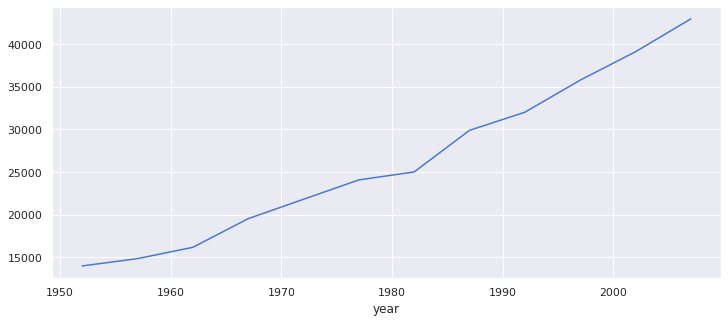

In [ ]:
usa['GDP'].plot(figsize=(12,5))

# Model (Basic)

## Hodrick-Prescott filter (trend+cycle) 
### (for component of trend, cyclical)

<div class="alert alert-info"><h3>Related Function:</h3>
<tt><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html'><strong>statsmodels.tsa.filters.hp_filter.hpfilter</strong></a><font color=black>(X, lamb=1600)</font>&nbsp;&nbsp;Hodrick-Prescott filter</div>
    
The <a href='https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter'>Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

The components are determined by minimizing the following quadratic loss function, where $\lambda$ is a smoothing parameter:

$\min_{\\{ \tau_{t}\\} }\sum_{t=1}^{T}c_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$


The $\lambda$ value above handles variations in the growth rate of the trend component.<br>When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
gdp_cycle, gdp_trend = hpfilter(usa['GDP'], lamb=6.25)

In [ ]:
type(gdp_trend)

pandas.core.series.Series

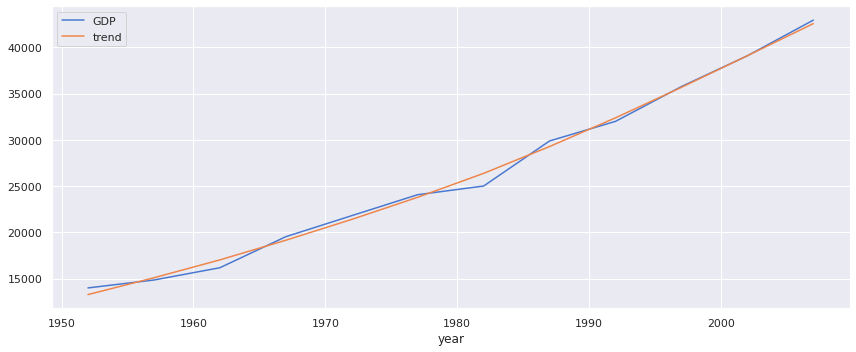

In [ ]:
usa['GDP'].plot(figsize=(12,5),label='GDP')
gdp_trend.plot(label='trend')
plt.legend()
plt.tight_layout()

In [ ]:
usa['trend']=gdp_trend
usa.head(1)

,country,pop,continent,lifeExp,GDP,trend
year,,,,,,
1952,United States,157553000.0,Americas,68.44,13990.48208,13271.592564


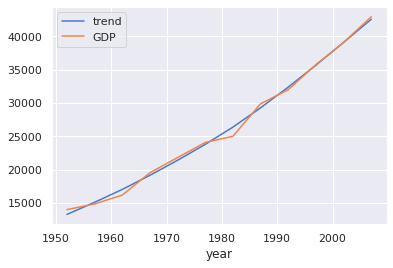

In [ ]:
usa[['trend','GDP']].plot()

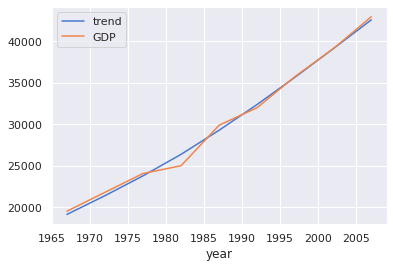

In [ ]:
usa.loc['1967':,['trend','GDP']].plot()

## ETS Decomposition

Error/Trend/Seasonality Models

As we begin working with <em>endogenous</em> data ("endog" for short) and start to develop forecasting models, it helps to identify and isolate factors working within the system that influence behavior. Here the name "endogenous" considers internal factors, while "exogenous" would relate to external forces. These fall under the category of <em>state space models</em>, and include <em>decomposition</em> (described below), and <em>exponential smoothing</em> (described in an upcoming section).

The <a href='https://en.wikipedia.org/wiki/Decomposition_of_time_series'>decomposition</a> of a time series attempts to isolate individual components such as <em>error</em>, <em>trend</em>, and <em>seasonality</em> (ETS). We've already seen a simplistic example of this in the <strong>Introduction to Statsmodels</strong> section with the Hodrick-Prescott filter. There we separated data into a trendline and a cyclical feature that mapped observed data back to the trend.

<div class="alert alert-info"><h3>Related Function:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html'>statsmodels.tsa.seasonal.seasonal_decompose</a></strong><font color=black>(x, model)</font>&nbsp;&nbsp;
Seasonal decomposition using moving averages</tt>
<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/ets.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Innovations state space models for exponential smoothing</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Decomposition_of_time_series'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Decomposition of time series</font></div>

Seasonal Decomposition
Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [ ]:
cov[cov['Positive']<0].sum()

Positive        0.0
Tested          0.0
Symptomatic     0.0
Asymptomatic    0.0
Sym-unknown     0.0
Discharged      0.0
Fatal           0.0
Hosp_require    0.0
Hosp_mild       0.0
Hosp_severe     0.0
Hosp_unknown    0.0
Hosp_waiting    0.0
dtype: float64

In [ ]:
cov=cov.asfreq('D',fill_value=0)

In [ ]:
cov.isnull().sum()

Positive        0
Tested          0
Symptomatic     0
Asymptomatic    0
Sym-unknown     0
Discharged      0
Fatal           0
Hosp_require    0
Hosp_mild       0
Hosp_severe     0
Hosp_unknown    0
Hosp_waiting    0
dtype: int64

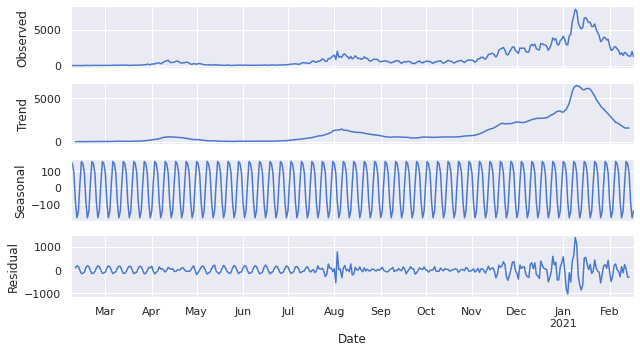

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 9, 5

result = seasonal_decompose(cov['Positive'], model='add')  # model='mul' also works
result.plot()
plt.show()

## SMA

In [ ]:
p=cov[['Positive']]
p['6-month-SMA'] = p['Positive'].rolling(window=3).mean()
p['12-month-SMA'] = p['Positive'].rolling(window=6).mean()

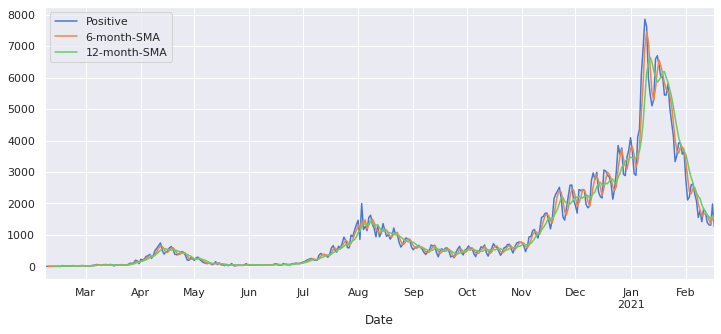

In [ ]:
p.plot(figsize=(12,5))

## EWMA

**Exponentially Weighted Moving Average **

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
 $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

 $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

 $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [ ]:
p['EWMA12'] = p['Positive'].ewm(span=6,adjust=False).mean()

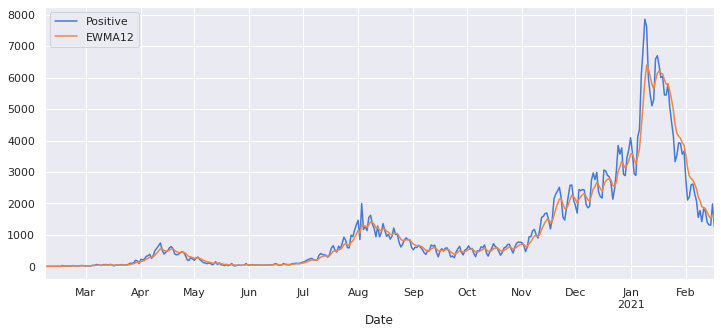

In [ ]:
p[['Positive','EWMA12']].plot(figsize=(12,5))

## SMA v.s. EWMA

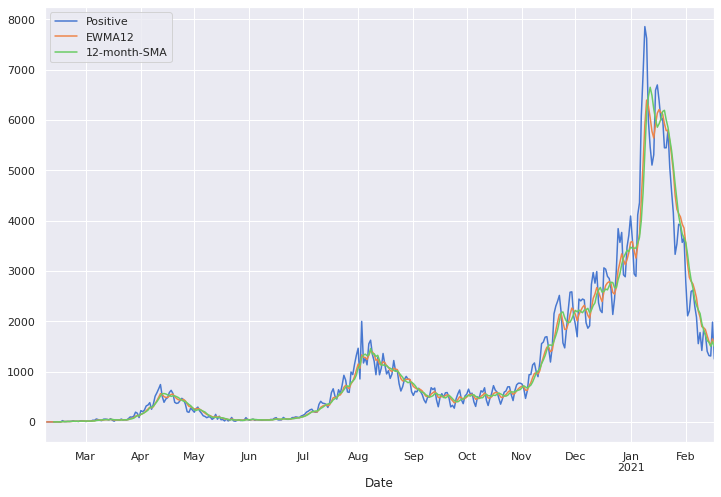

In [ ]:
p[['Positive','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

The above example employed Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at Double and Triple Exponential Smoothing with the Holt-Winters Methods.

## Holt Winters Method

In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h3>For Further Reading:</h3>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font color=black>What is Exponential Smoothing?</font></tt></div>

## Simple v.s. Double v.s. Triple

In [ ]:
air = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/airline_passengers.csv',index_col='Month',parse_dates=True)
air.dropna(inplace=True)
air.head(1)

,Thousands of Passengers
Month,
1949-01-01,112


**Setting a DatetimeIndex Frequency**

Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [ ]:
air.index.freq = 'MS'
air.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

___
### Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

air['EWMA12'] = air['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
air['SES12']=SimpleExpSmoothing(air['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
air.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

___
### Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

air['DESadd12'] = ExponentialSmoothing(air['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
air.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.336233
1949-02-01,118,112.923077,112.923077,120.336233
1949-03-01,132,115.857988,115.857988,134.336233
1949-04-01,129,117.879836,117.879836,131.336233
1949-05-01,121,118.359861,118.359861,123.336233


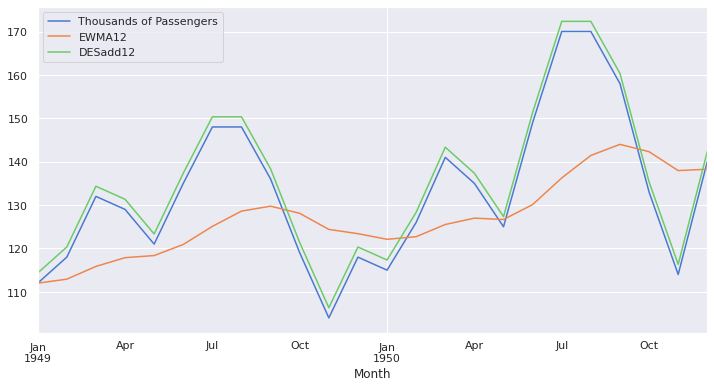

In [ ]:
air[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [ ]:
air['DESmul12'] = ExponentialSmoothing(air['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
air.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,112.049247
1949-02-01,118,112.923077,112.923077,120.336233,118.051885
1949-03-01,132,115.857988,115.857988,134.336233,132.058041
1949-04-01,129,117.879836,117.879836,131.336233,129.056722
1949-05-01,121,118.359861,118.359861,123.336233,121.053204


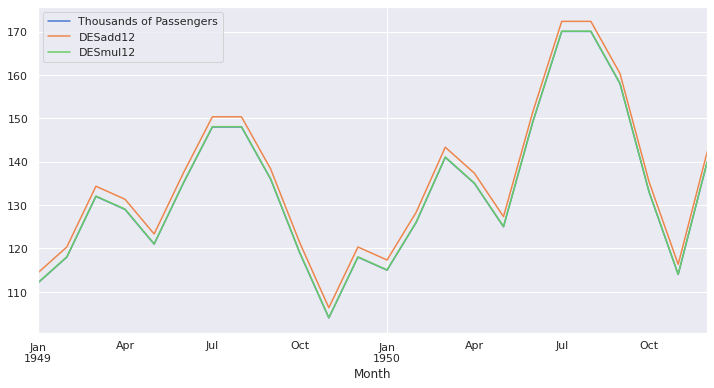

In [ ]:
air[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

___
### Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [ ]:
air['TESadd12'] = ExponentialSmoothing(air['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
air.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,112.049247,113.081288
1949-02-01,118,112.923077,112.923077,120.336233,118.051885,120.550747
1949-03-01,132,115.857988,115.857988,134.336233,132.058041,135.527329
1949-04-01,129,117.879836,117.879836,131.336233,129.056722,133.155064
1949-05-01,121,118.359861,118.359861,123.336233,121.053204,125.656114


In [ ]:
air['TESmul12'] = ExponentialSmoothing(air['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
air.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,112.049247,113.081288,111.583236
1949-02-01,118,112.923077,112.923077,120.336233,118.051885,120.550747,118.839294
1949-03-01,132,115.857988,115.857988,134.336233,132.058041,135.527329,133.327416
1949-04-01,129,117.879836,117.879836,131.336233,129.056722,133.155064,127.915388
1949-05-01,121,118.359861,118.359861,123.336233,121.053204,125.656114,120.978320


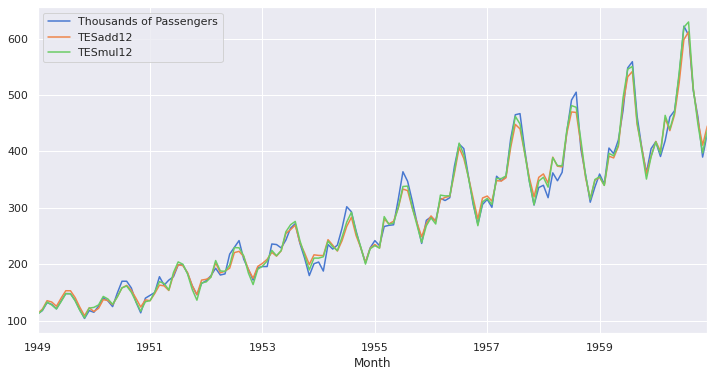

In [ ]:
air[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

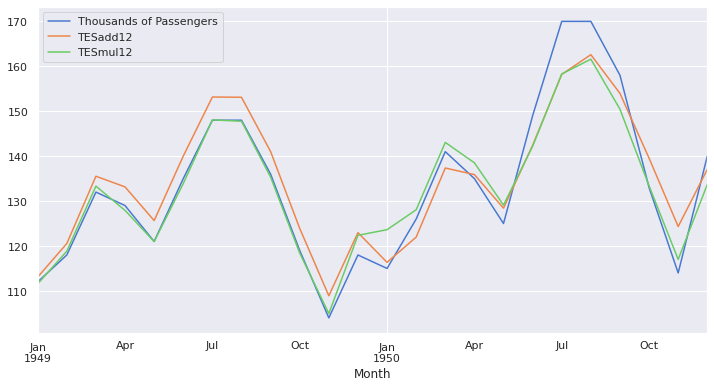

In [ ]:
air[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

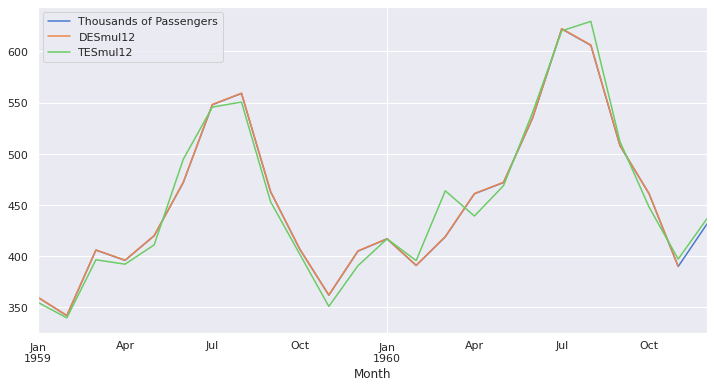

In [ ]:
air[['Thousands of Passengers','DESmul12','TESmul12']].iloc[-24:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Not focused on early time, but latest time. iloc[-24:]

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

But first, we'll work out some time series exercises before moving on to forecasting.

# Model (Forcasting)

## Forcasting Procedure



1.   choose a model
2.   split data into train and valid set
*   20%
*   ideally be at least as large as the
*   longer the forecast horizon, the more likely your prediction will become less accurate
3.   fit model on training set 
4.   evaluate model on valid set
5.   re-fit model on entire data set
6.   forecast for future data

## Train Test Split

In [ ]:
df=pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq='MS'

In [ ]:
train_data = df.iloc[:108] # Goes up to but not including 108
test_data = df.iloc[108:]

## Fitting the Model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],
                                    trend='mul',
                                    seasonal='mul',
                                    seasonal_periods=12).fit()

## Evaluating Model against Test Set

In [ ]:
# YOU CAN SAFELY IGNORE WARNINGS HERE!
# THIS WILL NOT AFFECT YOUR FORECAST, IT'S JUST SOMETHING STATSMODELS NEEDS TO UPDATE UPON NEXT RELEASE.
test_predictions = fitted_model.forecast(36).rename('HW Forecast')

In [ ]:
test_predictions

1958-01-01    356.739143
1958-02-01    343.561234
1958-03-01    403.996804
1958-04-01    397.853537
1958-05-01    406.415919
1958-06-01    479.824369
1958-07-01    529.820371
1958-08-01    524.772030
1958-09-01    454.714920
1958-10-01    391.965458
1958-11-01    345.259663
1958-12-01    395.243838
1959-01-01    407.506420
1959-02-01    392.453174
1959-03-01    461.489283
1959-04-01    454.471773
1959-05-01    464.252661
1959-06-01    548.107812
1959-07-01    605.218708
1959-08-01    599.451941
1959-09-01    519.425056
1959-10-01    447.745766
1959-11-01    394.393305
1959-12-01    451.490690
1960-01-01    465.498351
1960-02-01    448.302888
1960-03-01    527.163474
1960-04-01    519.147307
1960-05-01    530.320106
1960-06-01    626.108620
1960-07-01    691.346924
1960-08-01    684.759493
1960-09-01    593.344043
1960-10-01    511.464127
1960-11-01    450.519118
1960-12-01    515.741989
Freq: MS, Name: HW Forecast, dtype: float64

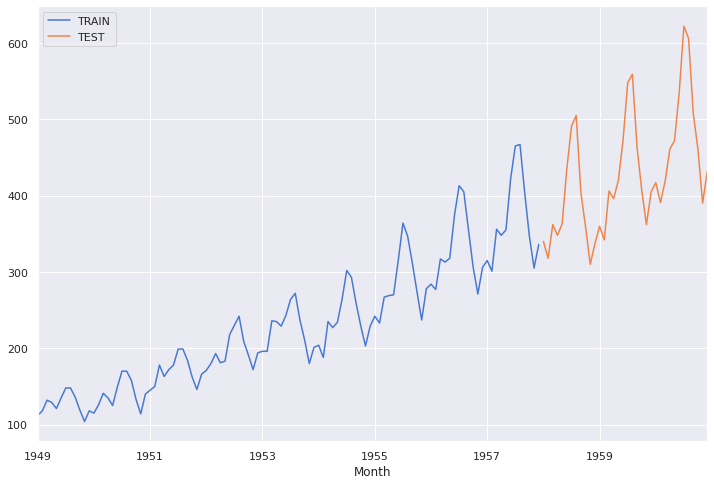

In [ ]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8));

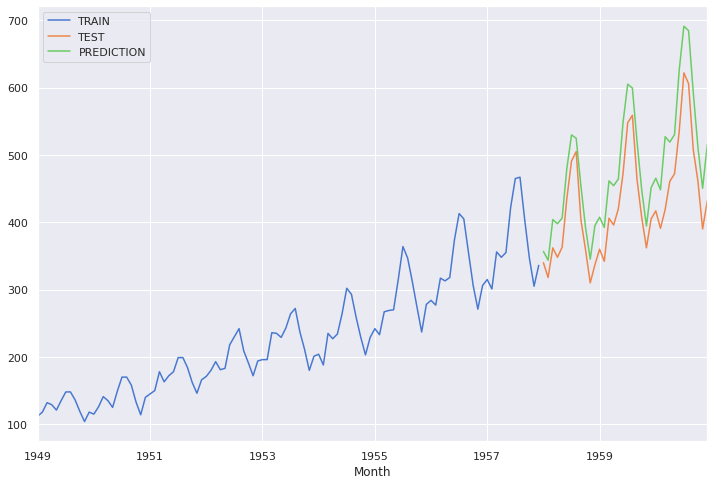

In [ ]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

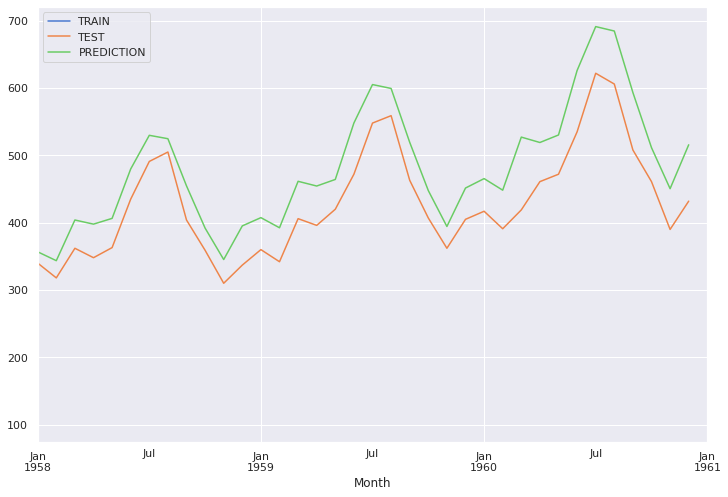

In [ ]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

## Evaluation Metrics


*   Mean Absolute Error
*   Mean Squared Error (Note large value)
*   Root Mean Square Error (Unit, Most Popular)



In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
mean_absolute_error(test_data,test_predictions)

53.16361991340851

In [ ]:
mean_squared_error(test_data,test_predictions)

3200.583445912333

In [ ]:
np.sqrt(mean_squared_error(test_data,test_predictions))

56.57369924189449

In [ ]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


## Forecasting into Future

In [ ]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'],
                                   trend='mul',
                                   seasonal='mul',
                                   seasonal_periods=12).fit()

In [ ]:
forecast_predictions = final_model.forecast(36)

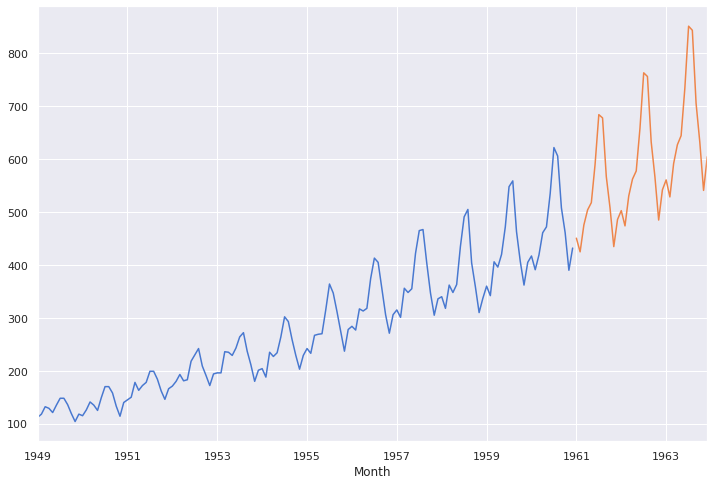

In [ ]:
df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_predictions.plot();

# Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

<div class="alert alert-info"><h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/stationarity.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Stationarity and differencing</font></div>

In [ ]:
df2 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/samples.csv',index_col=0,parse_dates=True)
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


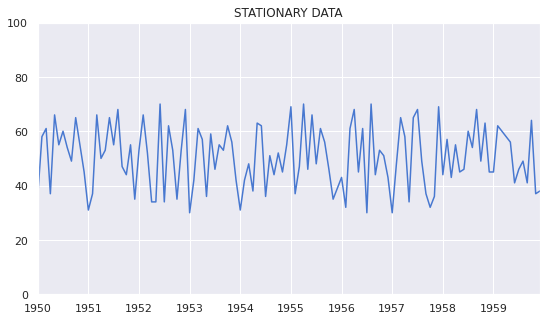

In [ ]:
df2['a'].plot(ylim=[0,100],title="STATIONARY DATA").autoscale(axis='x',tight=True);

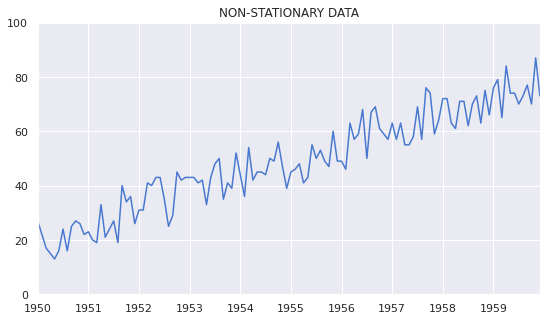

In [ ]:
df2['b'].plot(ylim=[0,100],title="NON-STATIONARY DATA").autoscale(axis='x',tight=True);

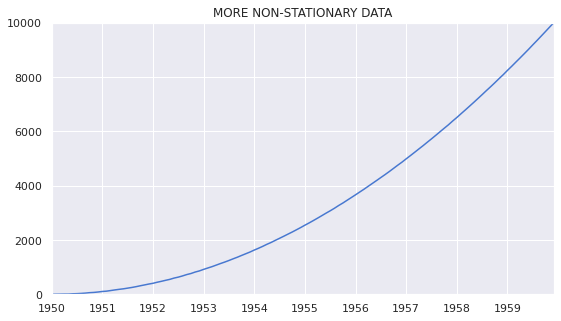

In [ ]:
df2['c'].plot(ylim=[0,10000],title="MORE NON-STATIONARY DATA").autoscale(axis='x',tight=True);

In an upcoming section we'll learn how to test for stationarity.

# Differencing
## First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.


In [ ]:
# Calculate the first difference of the non-stationary dataset "b"
df2['d1b'] = df2['b'] - df2['b'].shift(1)

df2[['b','d1b']].head()

,b,d1b
1950-01-01,27,NaN
1950-02-01,22,-5.0
1950-03-01,17,-5.0
1950-04-01,15,-2.0
1950-05-01,13,-2.0


Notice that differencing eliminates one or more rows of data from the beginning of the series.

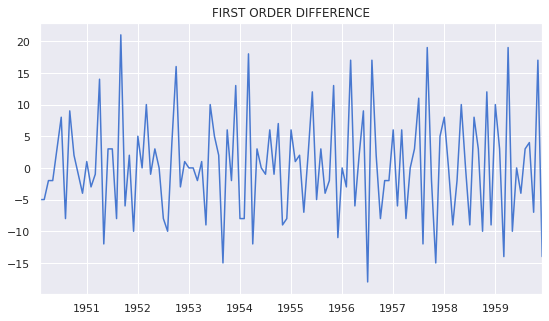

In [ ]:
df2['d1b'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

An easier way to perform differencing on a pandas Series or DataFrame is to use the built-in <tt>.diff()</tt> method:

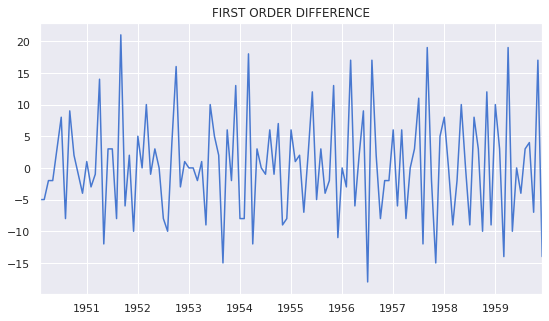

In [ ]:
df2['d1b'] = df2['b'].diff()

df2['d1b'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

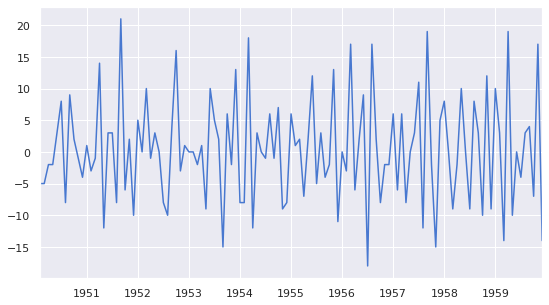

In [ ]:
from statsmodels.tsa.statespace.tools import diff

diff(df2['b'],k_diff=1).plot()

In [ ]:
# For our example we need to build a forecast series from scratch
# First determine the most recent date in the training set, to know where the forecast set should start
df2[['b']].tail(3)

,b
1959-10-01,70
1959-11-01,87
1959-12-01,73


In [ ]:
# Next set a DateTime index for the forecast set that extends 5 periods into the future
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


The idea behind an inverse transformation is to start with the most recent value from the training set, and to add a cumulative sum of Fcast values to build the new forecast set. For this we'll use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [ ]:
z['forecast']=df2['b'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,forecast
1960-01-01,7,80
1960-02-01,-2,78
1960-03-01,5,83
1960-04-01,-1,82
1960-05-01,12,94


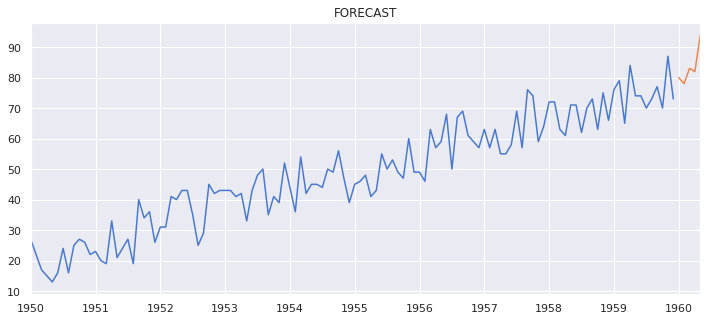

In [ ]:
df2['b'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

## Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

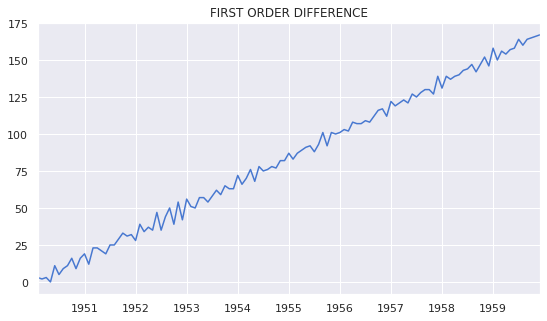

In [ ]:
# First we'll look at the first order difference of dataset "c"
df2['d1c'] = df2['c'].diff()

df2['d1c'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

Now let's apply a second order difference to dataset "c".

In [ ]:
# We can do this from the original time series in one step
df2['d2c'] = df2['c'].diff().diff()

df2[['c','d1c','d2c']].head()

,c,d1c,d2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.0,NaN
1950-03-01,5,2.0,-1.0
1950-04-01,8,3.0,1.0
1950-05-01,8,0.0,-3.0


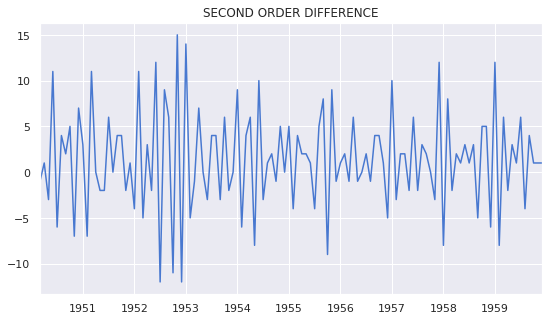

In [ ]:
df2['d2c'].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

<div class="alert alert-info"><strong>NOTE: </strong>This is different from <font color=black><tt>df2['c'].diff(2)</tt></font>, which would provide a first order difference spaced 2 lags apart.<br>
We'll use this technique later to address seasonality.</div>

### Forecasting on second order differenced data
As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to <tt>df['d2c']</tt> are <tt>[7,-2,5,-1,12]</tt>.

In [ ]:
# For our example we need to build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


One way to invert a 2nd order transformation is to follow the formula above:

In [ ]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df2['c'].iloc[-2:]

# Apply the formula
for i in z['Fcast']:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

z['forecast']=forecast
z

,Fcast,forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


Another, perhaps more straightforward method is to create a first difference set from the second, then build the forecast set from the first difference. We'll again use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [ ]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df2['c'].iloc[-1]-df2['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df2['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


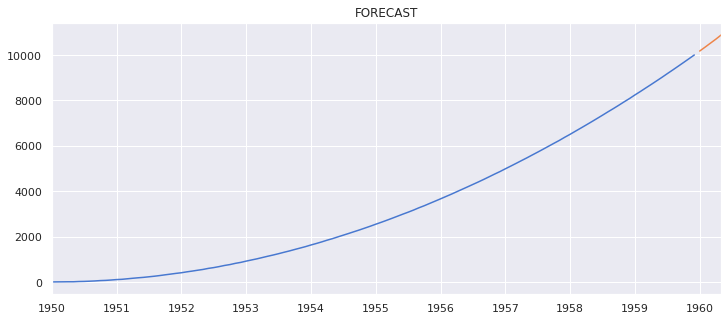

In [ ]:
df2['c'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

<div class="alert alert-danger"><strong>NOTE:</strong> statsmodels has a built-in differencing tool:<br>
    
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;from statsmodels.tsa.statespace.tools import diff<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;df2['d1'] = diff(df2['b'],k_diff=1)</font></tt><br><br>
    
that performs the same first order differencing operation shown above. We chose not to use it here because seasonal differencing is somewhat complicated. To difference based on 12 lags, the code would be<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = diff(df2['b'],k_diff=0,k_seasonal_diff=1,seasonal_periods=12)
</font></tt><br><br>

whereas with pandas it's simply<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = df2['b'].diff(12)
</font></tt>
</div>

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Great, let's get started!

# ACF and PACF

*   ACF: describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information
*   PACF: only describes the direct relationship between an observation and its lag

## Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


## Perform standard imports and load datasets

In [ ]:
import statsmodels.api as sm

# Load a non-stationary dataset
df1 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [ ]:
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

### Ignore harmless warnings
A quick note before we get started. Many of the models used in this and upcoming sections are likely to raise harmless warnings.<br>For instance, the unbiased partial autocorrelation <tt>pacf_yw()</tt> performed below may raise a <tt>RuntimeWarning: invalid value encountered in sqrt</tt>.<br>
We don't really need to be concerned with this, and we can avoid it with the following code:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


<div class="alert alert-info"><strong>A NOTE ON FORMULA CONVENTIONS:</strong> Different texts employ different symbol conventions. For example, in the above autocovariance formula we use $k$ to represent the amount of lag or shift. Some texts use $h$ instead.</div>


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [ ]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [ ]:
arr2 = acovf(df['a'],unbiased=True)
arr2

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [ ]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [ ]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

<div class="alert alert-info"><strong>NOTE:</strong> We passed in <tt><font color=black>method='mle'</font></tt> above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass <tt>method='unbiased'</tt> (the statsmodels default):</div>

In [ ]:
arr5 = pacf_yw(df['a'],nlags=4,method='unbiased')
arr5

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

### Partial Autocorrelation with OLS
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [ ]:
arr6 = pacf_ols(df['a'],nlags=4)
arr6

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

# Plotting
The arrays returned by <tt>.acf(df)</tt> and <tt>.pacf_yw(df)</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


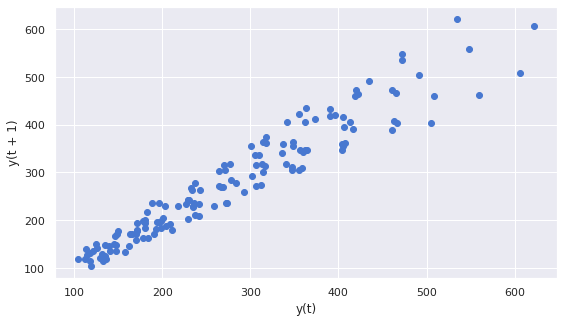

In [ ]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

Now let's look at the stationary <strong>Daily Total Female Births</strong> dataset:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


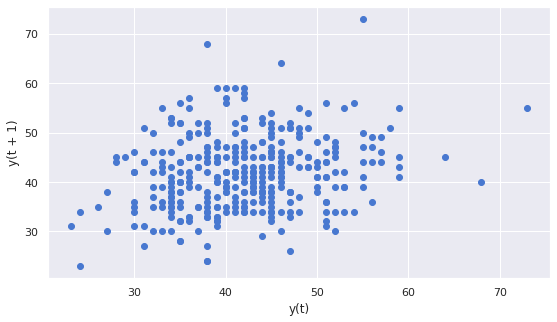

In [ ]:
lag_plot(df2['Births']);

As expected, there is little evidence of autocorrelation here.

## ACF Plots

Plotting the magnitude of the autocorrelations over the first few (20-40) lags can say a lot about a time series.

For example, consider the stationary <strong>Daily Total Female Births</strong> dataset:

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Let's look first at the ACF array. By default acf() returns 40 lags
acf(df2['Births'])

array([ 1.        ,  0.21724118,  0.15287758,  0.10821254,  0.09066059,
        0.09595481,  0.09104012,  0.19508071,  0.14115295,  0.06117859,
        0.04781522,  0.04770662, -0.01964707,  0.02287422,  0.08112657,
        0.11185686,  0.07333732,  0.01501845,  0.07270333,  0.06859   ,
        0.09280107,  0.26386846,  0.14012147,  0.06070286,  0.08716232,
        0.05038825,  0.0650489 ,  0.11466565,  0.1552232 ,  0.12850638,
        0.10358981,  0.09734643,  0.04912286,  0.04022798,  0.05838555,
        0.05359812,  0.10151053,  0.08268663,  0.0912185 ,  0.11192192,
        0.05652846])

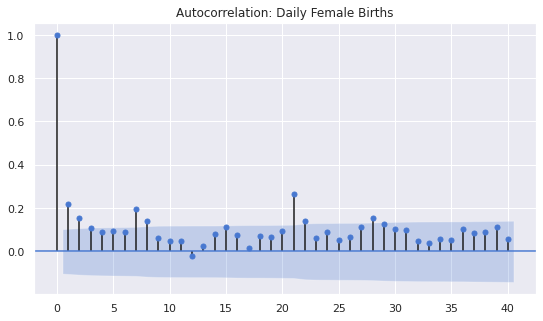

In [ ]:
# TYPE: Sharp Drop-off
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the <strong>Airline Passengers</strong> dataset:

In [ ]:
acf(df1['Thousands of Passengers'])

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

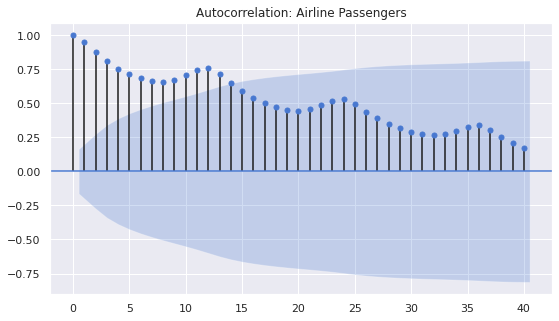

In [ ]:
# TYPE: Gradual Decline
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

## PACF Plots
Partial autocorrelations work best with stationary data. Let's look first at <strong>Daily Total Female Births</strong>:

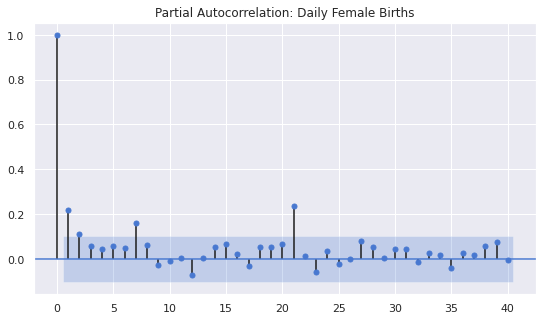

In [ ]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

To make the <strong>Airline Passengers</strong> data stationary, we'll first apply <em>differencing</em>:

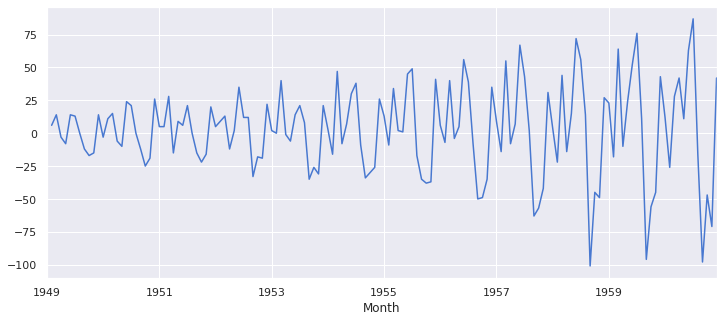

In [ ]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot(figsize=(12,5));

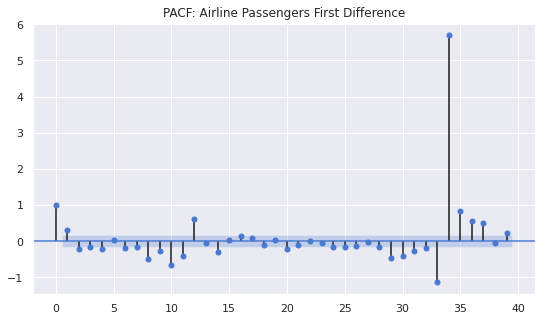

In [ ]:
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

### Plot Resizing
In case you want to display the full autocorrelation plot, it helps to increase the figure size using matplotlib:

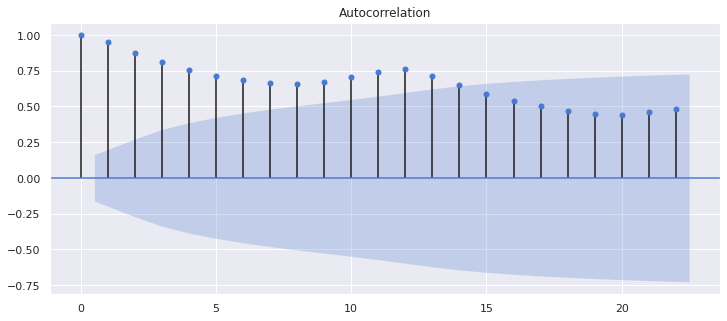

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(df1['Thousands of Passengers'],ax=ax);

<div class="alert alert-success"><strong>A NOTE ABOUT AUTOCORRELATION:</strong> Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>

## Stationary v.s. Non-Stationary

Stationary


1.   constant mean and variance over time
2.   variance should not be a function of time
3.   covariance should not be a function of time



Test: Augmented Dickey-Fuller test

* if not, transform it to be stationary in order to evaluate it and what type of ARIMA term to use
* differencing: original data --> first difference --> second difference

# AR(p)
# Autoregressive Model
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/AR.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive models</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive model</font></div>

## Perform standard imports and load datasets
For this exercise we'll look at monthly U.S. population estimates in thousands from January 2011 to December 2018 (96 records, 8 years of data). Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month.
Source: https://fred.stlouisfed.org/series/POPTHM

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

# Load the U.S. Population dataset
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [ ]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


## Plot the source data

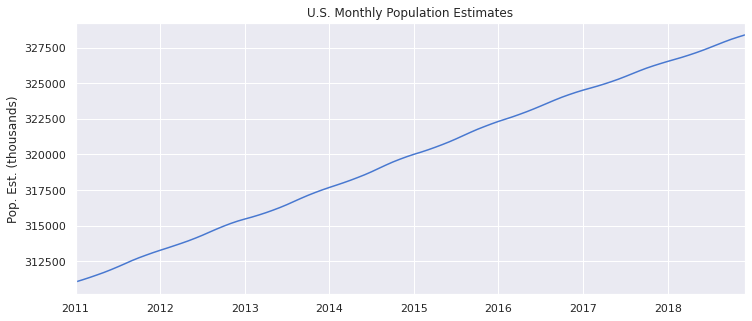

In [ ]:
title='U.S. Monthly Population Estimates'
ylabel='Pop. Est. (thousands)'
xlabel='' # we don't really need a label here

ax = df['PopEst'].plot(figsize=(12,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

<div class="alert alert-info"><strong>NOTE: </strong>For many training and testing applications we would use the <tt>train_test_split()</tt> function available from Python's <a href='https://scikit-learn.org/stable/'>scikit-learn</a> library. This won't work here as <tt>train_test_split()</tt> takes <em>random samples</em> of data from the population.</div>

In [ ]:
len(df)

96

In [ ]:
# Set one year for testing
train = df.iloc[:84]
test = df.iloc[84:]

## Fit an AR(1) Model

In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = AR(train['PopEst'])
# NOTE: We passed in method='mle' above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass method='unbiased' (the statsmodels default):
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        239.608395
L1.PopEst      0.999249
dtype: float64


<div class="alert alert-info"><strong>NOTE: </strong>There's a slight difference between the object returned by the Holt-Winters Exponential Smoothing <tt>.fit()</tt> method and that returned by AR. The Holt-Winters object uses <tt>.forecast()</tt> for predicted values, while AR uses <tt>.predict()</tt>.</div>

In [ ]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [ ]:
predictions1

2018-01-01    326372.439456
2018-02-01    326366.883090
2018-03-01    326361.330897
2018-04-01    326355.782875
2018-05-01    326350.239021
2018-06-01    326344.699331
2018-07-01    326339.163802
2018-08-01    326333.632432
2018-09-01    326328.105216
2018-10-01    326322.582153
2018-11-01    326317.063238
2018-12-01    326311.548469
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [ ]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test['PopEst'][i]}")

predicted=326372.4395, expected=326527
predicted=326366.8831, expected=326669
predicted=326361.3309, expected=326812
predicted=326355.7829, expected=326968
predicted=326350.239 , expected=327134
predicted=326344.6993, expected=327312
predicted=326339.1638, expected=327502
predicted=326333.6324, expected=327698
predicted=326328.1052, expected=327893
predicted=326322.5822, expected=328077
predicted=326317.0632, expected=328241
predicted=326311.5485, expected=328393


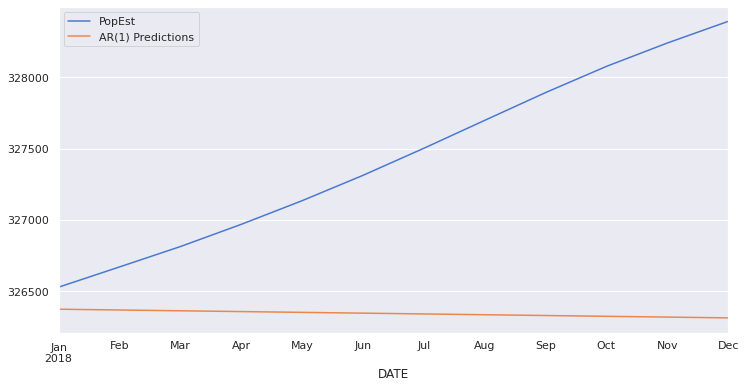

In [ ]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Fit an AR(2) Model

In [ ]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        119.907722
L1.PopEst      1.996371
L2.PopEst     -0.996747
dtype: float64


In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

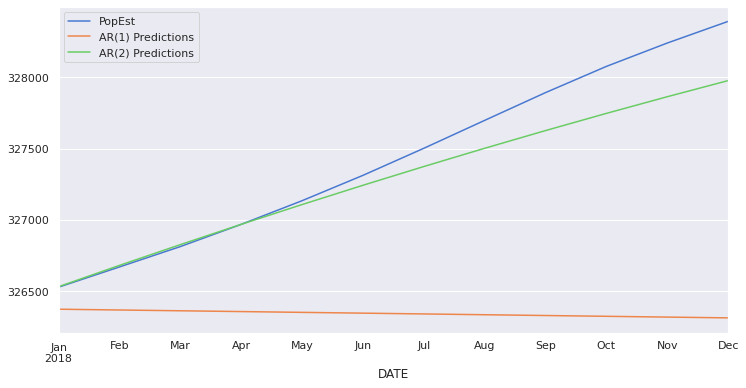

In [ ]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [ ]:
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 11
Coefficients:
const         96.211909
L1.PopEst      2.230894
L2.PopEst     -1.983321
L3.PopEst      1.515178
L4.PopEst     -1.440421
L5.PopEst      1.202985
L6.PopEst     -1.162426
L7.PopEst      1.006187
L8.PopEst     -0.591689
L9.PopEst      0.591492
L10.PopEst    -0.338822
L11.PopEst    -0.030358
dtype: float64


In [ ]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

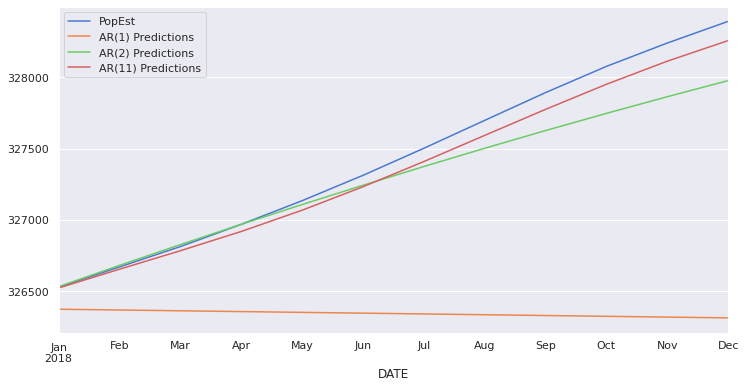

In [ ]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [ ]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1584797.132
AR(2) Error: 46289.81783
AR(11) Error: 8199.840802


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [ ]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 3.3939
AR(2) AIC: 3.4177
AR(11) AIC:  3.632


## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

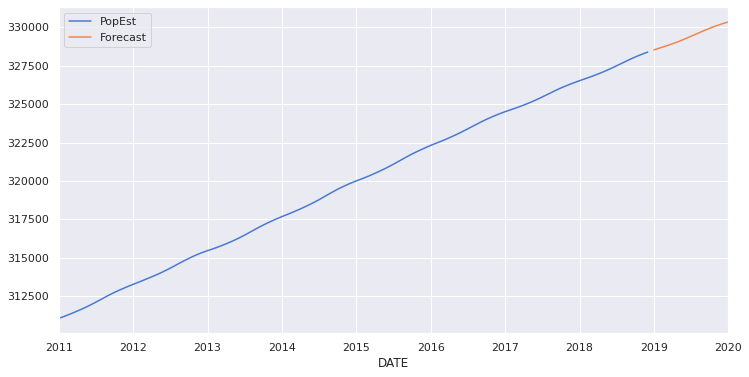

In [ ]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+12, dynamic=False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

# Descriptive Statistics and Tests
In upcoming sections we'll talk about different forecasting models like ARMA, ARIMA, Seasonal ARIMA and others. Each model addresses a different type of time series. For this reason, in order to select an appropriate model we need to know something about the data.

In this section we'll learn how to determine if a time series is <em>stationary</em>, if it's <em>independent</em>, and if two series demonstrate <em>correlation</em> and/or <em>causality</em>.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.ccovf.html'>stattools.ccovf</a></strong><font color=black>(x, y[, unbiased, demean])</font>&nbsp;&nbsp;crosscovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.ccf.html'>stattools.ccf</a></strong><font color=black>(x, y[, unbiased])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cross-correlation function for 1d<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.periodogram.html'>stattools.periodogram</a></strong><font color=black>(X)</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Returns the periodogram for the natural frequency of X<br>
    
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html'>stattools.adfuller</a></strong><font color=black>(x[, maxlag, regression, …])</font>&nbsp;&nbsp;Augmented Dickey-Fuller unit root test<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html'>stattools.kpss</a></strong><font color=black>(x[, regression, lags, store])</font>&nbsp;&nbsp;&nbsp;&nbsp;Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html'>stattools.coint</a></strong><font color=black>(y0, y1[, trend, method, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Test for no-cointegration of a univariate equation<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.bds.html'>stattools.bds</a></strong><font color=black>(x[, max_dim, epsilon, distance])</font>&nbsp;&nbsp;Calculate the BDS test statistic for independence of a time series<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.q_stat.html'>stattools.q_stat</a></strong><font color=black>(x, nobs[, type])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Returns Ljung-Box Q Statistic<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html'>stattools.grangercausalitytests</a></strong><font color=black>(x, maxlag[, …])</font>&nbsp;Four tests for granger non-causality of 2 timeseries<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.levinson_durbin.html'>stattools.levinson_durbin</a></strong><font color=black>(s[, nlags, isacov])</font>&nbsp;&nbsp;&nbsp;Levinson-Durbin recursion for autoregressive processes<br>

<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tools.eval_measures.mse.html'>stattools.eval_measures.mse</a></strong><font color=black>(x1, x2, axis=0)</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mean squared error<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tools.eval_measures.rmse.html'>stattools.eval_measures.rmse</a></strong><font color=black>(x1, x2, axis=0)</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;root mean squared error<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tools.eval_measures.meanabs.html'>stattools.eval_measures.meanabs</a></strong><font color=black>(x1, x2, axis=0)</font>&nbsp;&nbsp;mean absolute error<br>
</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Augmented Dickey–Fuller test</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/KPSS_test'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Kwiatkowski-Phillips-Schmidt-Shin test</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Granger_causality'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Granger causality test</font><br>
<strong>
<a href='https://otexts.com/fpp2/accuracy.html'>Forecasting: Principles and Practice:</a></strong>&nbsp;&nbsp;<font color=black>Evaluating forecast accuracy</font>

</div>



# Tests for Stationarity
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

In [ ]:
from statsmodels.tsa.stattools import ccovf,ccf,periodogram

In [ ]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [ ]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Alternative:
# from sklearn.metrics import mean_squared_error

## Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

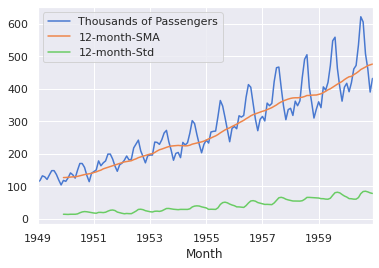

In [ ]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well.

In [ ]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(0.8153688792060418,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.578770059171598,
  '5%': -2.8840418343195267},
 996.692930839019)

To find out what these values represent we can run <tt>help(adfuller)</tt>. Then we can add our own labels:

In [ ]:
print('Augmented Dickey-Fuller Test on Airline Data')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64


Here we have a very high p-value at 0.99, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.<br>
Note: in statistics we don't "accept" a null hypothesis - nothing is ever truly proven - we just fail to reject it.
<br><br>
Now let's apply the ADF test to stationary data with the Daily Total Female Births dataset.

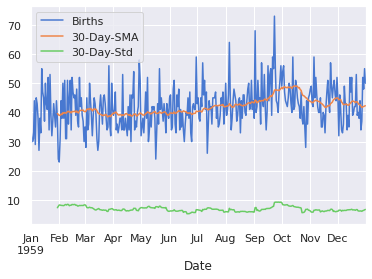

In [ ]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [ ]:
print('Augmented Dickey-Fuller Test on Daily Female Births')
dftest = adfuller(df2['Births'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Daily Female Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
dtype: float64


In this case our p-value is very low at 0.000052, and we do reject the null hypothesis. This dataset appears to have no unit root, and is stationary.

### Function for running the augmented Dickey-Fuller test
Since we'll use it frequently in the upcoming forecasts, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

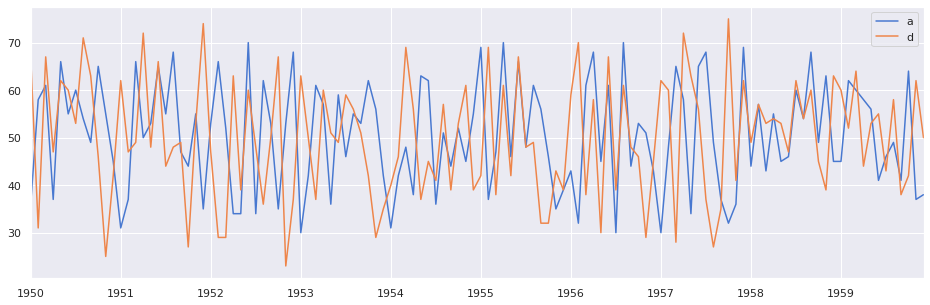

In [ ]:
df3 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));

It's hard to tell from this overlay but <tt>df['d']</tt> almost perfectly predicts the behavior of <tt>df['a']</tt>.<br>
To see this more clearly (spoiler alert!), we will shift <tt>df['d']</tt> two periods forward.

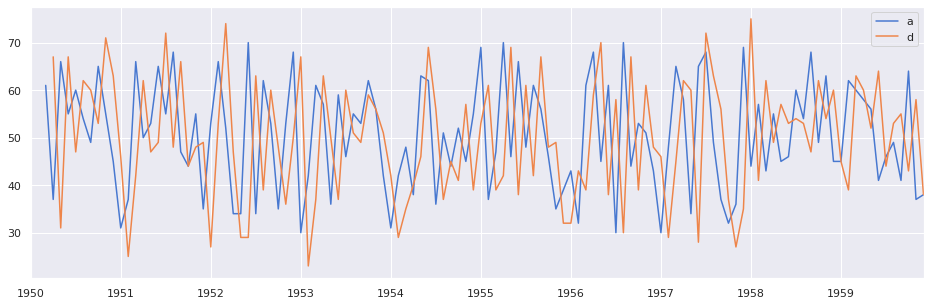

In [ ]:
df3['a'].iloc[2:].plot(figsize=(16,5),legend=True);
df3['d'].shift(3).plot(legend=True);

### Run the test
The function takes in a 2D array [y,x] and a maximum number of lags to test on x. Here our y is column 'a' and x is column 'd'. We'll set maxlags to 3.

In [ ]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


Essentially we're looking for extremely low p-values, which we see at lag 2.<br>
By comparison, let's compare two datasets that are not at all similar, 'b' and 'd'.

In [ ]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


### Dive further with your domain knowledge

# Evaluating forecast accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

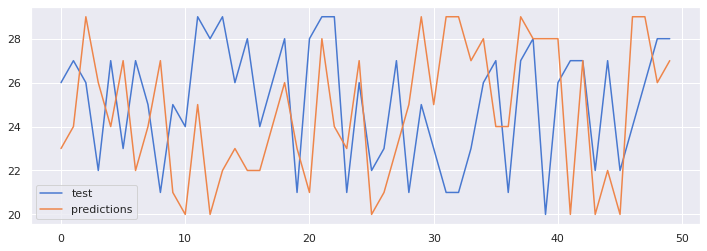

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])
df.plot(figsize=(12,4));

In [ ]:
MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


### AIC / BIC
More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

## Exposing Seasonality with Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.
<div class="alert alert-info"><h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html'>tsaplots.month_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;&nbsp;Seasonal plot of monthly data<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html'>tsaplots.quarter_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Seasonal plot of quarterly data</tt>
</div>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


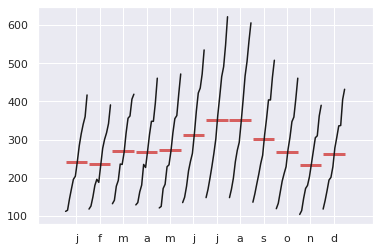

In [ ]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df['Thousands of Passengers']);

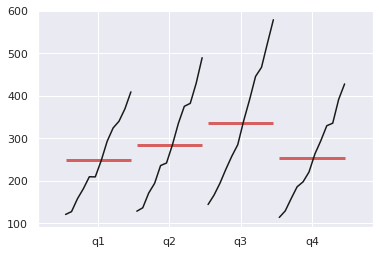

In [ ]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()

quarter_plot(dfq);

Let's compare this to our nonseasonal <tt>macrodata.csv</tt> dataset:

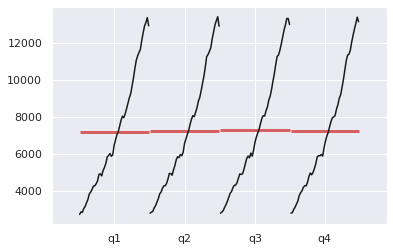

In [ ]:
df3 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/macrodata.csv',index_col=0,parse_dates=True)
quarter_plot(df3['realgdp']);

# Choosing ARIMA Orders

* Goals
  * Understand PDQ terms for ARIMA (slides)
  * Understand how to choose orders manually from ACF and PACF
  * Understand how to use automatic order selection techniques using the functions below
  
Before we can apply an ARIMA forecasting model, we need to review the components of one.<br>
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt>
<strong>
<a href='https://www.alkaline-ml.com/pmdarima/user_guide.html#user-guide'>pmdarima.auto_arima</a></strong><font color=black>(y[,start_p,d,start_q, …])</font>&nbsp;&nbsp;&nbsp;Returns the optimal order for an ARIMA model<br>

<h3>Optional Function (see note below):</h3>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html'>stattools.arma_order_select_ic</a></strong><font color=black>(y[, max_ar, …])</font>&nbsp;&nbsp;Returns information criteria for many ARMA models<br><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_select_order.html'>x13.x13_arima_select_order</a></strong><font color=black>(endog[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Perform automatic seasonal ARIMA order identification using x12/x13 ARIMA</tt></div>

## Perform standard imports and load datasets

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load a non-stationary dataset
df1 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

## pmdarima Auto-ARIMA
This is a third-party tool separate from statsmodels. It should already be installed if you're using our virtual environment. If not, then at a terminal run:<br>
&nbsp;&nbsp;&nbsp;&nbsp;<tt>pip install pmdarima</tt>

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 25.9MB/s 
     |████████████████████████████████| 9.5MB 41.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


Let's look first at the stationary, non-seasonal <strong>Daily Female Births</strong> dataset:

In [ ]:
auto_arima(df2['Births'])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

<div class="alert alert-info"><strong>NOTE: </strong>Harmless warnings should have been suppressed, but if you see an error citing unusual behavior you can suppress this message by passing <font color=black><tt>error_action='ignore'</tt></font> into <tt>auto_arima()</tt>. Also, <font color=black><tt>auto_arima().summary()</tt></font> provides a nicely formatted summary table.</div>

In [ ]:
auto_arima(df2['Births'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Mon, 31 May 2021   AIC                           2459.074
Time:                        14:02:53   BIC                           2470.766
Sample:                             0   HQIC                          2463.721
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (Q):                       37.21   Jarque-Bera (JB):                25.33
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This shows a recommended (p,d,q) ARIMA Order of (1,1,1), with no seasonal_order component.

We can see how this was determined by looking at the stepwise results. The recommended order is the one with the lowest <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> or AIC score. Note that the recommended model may <em>not</em> be the one with the closest fit. The AIC score takes complexity into account, and tries to identify the best <em>forecasting</em> model.

In [ ]:
stepwise_fit = auto_arima(df2['Births'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2650.760, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2565.234, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2463.584, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2648.768, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2460.154, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2461.271, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2460.722, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2536.154, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2463.046, Time=0.87 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.074, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2462.221, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2563.261, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.367, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Mon, 31 May 2021   AIC                           2459.074
Time:                        14:02:57   BIC                           2470.766
Sample:                             0   HQIC                          2463.721
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (Q):                       37.21   Jarque-Bera (JB):                25.33
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

___
Now let's look at the non-stationary, seasonal <strong>Airline Passengers</strong> dataset:

In [ ]:
stepwise_fit = auto_arima(df1['Thousands of Passengers'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.36 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.78 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=1.03 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -505.589
Date:                            Mon, 31 May 2021   AIC                           1019.178
Time:                                    14:03:15   BIC                           1030.679
Sample:                                         0   HQIC                          1023.851
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (Q):                       53.71   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.07   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## OPTIONAL: statsmodels ARMA_Order_Select_IC
Statsmodels has a selection tool to find orders for ARMA models on stationary data.

In [ ]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [ ]:
help(arma_order_select_ic)

Help on function arma_order_select_ic in module statsmodels.tsa.stattools:

arma_order_select_ic(y, max_ar=4, max_ma=2, ic='bic', trend='c', model_kw=None, fit_kw=None)
    Returns information criteria for many ARMA models
    
    Parameters
    ----------
    y : array-like
        Time-series data
    max_ar : int
        Maximum number of AR lags to use. Default 4.
    max_ma : int
        Maximum number of MA lags to use. Default 2.
    ic : str, list
        Information criteria to report. Either a single string or a list
        of different criteria is possible.
    trend : str
        The trend to use when fitting the ARMA models.
    model_kw : dict
        Keyword arguments to be passed to the ``ARMA`` model
    fit_kw : dict
        Keyword arguments to be passed to ``ARMA.fit``.
    
    Returns
    -------
    obj : Results object
        Each ic is an attribute with a DataFrame for the results. The AR order
        used is the row index. The ma order used is the column i

In [ ]:
arma_order_select_ic(df2['Births'])

{'bic':              0            1            2
 0  2502.581666  2494.238827  2494.731525
 1  2490.780306  2484.505386  2486.223523
 2  2491.963234  2485.782753  2491.097205
 3  2496.498618  2491.061564  2496.961178
 4  2501.491891  2504.012601  2498.329743, 'bic_min_order': (1, 1)}

In [ ]:
arma_order_select_ic(df1['Thousands of Passengers'])

{'bic':              0            1            2
 0  1796.307207  1627.771967  1534.002384
 1  1437.088819  1421.627523  1425.899321
 2  1425.518037  1423.098290  1482.256168
 3  1425.191373  1413.107820  1400.085468
 4  1427.576573  1528.773937  1415.541177, 'bic_min_order': (3, 2)}

<div class="alert alert-success"><strong>A note about <tt>statsmodels.tsa.x13.x13_arima_select_order</tt></strong><br><br>
This utility requires installation of <strong>X-13ARIMA-SEATS</strong>, a seasonal adjustment tool developed by the U.S. Census Bureau.<br>
See <a href='https://www.census.gov/srd/www/x13as/'>https://www.census.gov/srd/www/x13as/</a> for details. Since the installation requires adding x13as to your PATH settings we've deemed it beyond the scope of this course.

# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

## Perform standard imports and load datasets

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

___
## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.
### Plot the source data

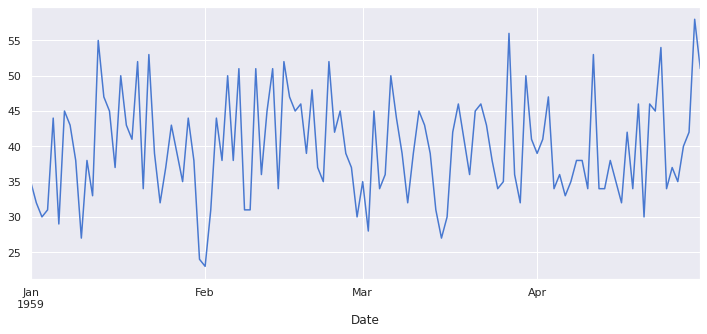

In [ ]:
df1['Births'].plot(figsize=(12,5));

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [ ]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [ ]:
auto_arima(df1['Births'],seasonal=False)

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Mon, 31 May 2021   AIC                            823.489
Time:                        14:32:52   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (Q):                       44.41   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.29   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [ ]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being returned.

In [ ]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Mon, 31 May 2021   AIC                            627.809
Time:                        14:04:05   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### Plot predictions against known values

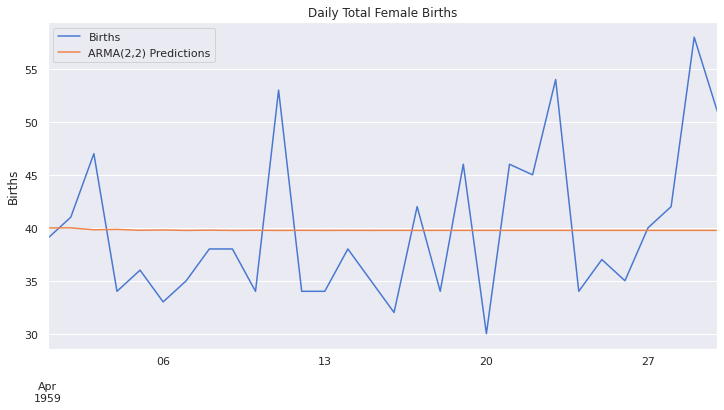

In [ ]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

___
## Autoregressive Integrated Moving Average - ARIMA(p,d,q)
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>
First let's take a look at the <em>Real Manufacturing and Trade Inventories</em> dataset.
### Plot the Source Data

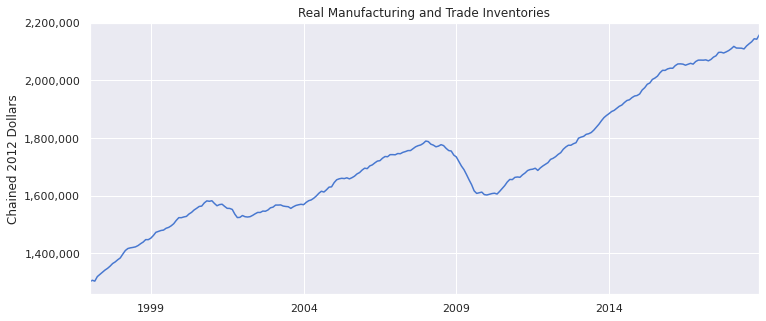

In [ ]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Run an ETS Decomposition (optional)
We probably won't learn a lot from it, but it never hurts to run an ETS Decomposition plot.

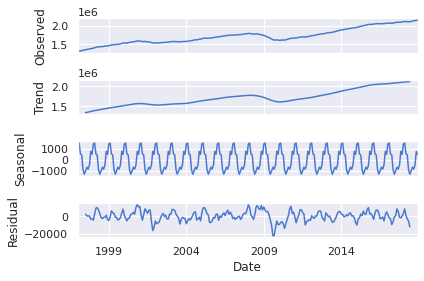

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [ ]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Mon, 31 May 2021   AIC                           5348.037
Time:                        14:04:08   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This suggests that we should fit an ARIMA(1,1,1) model to best forecast future values of the series. Before we train the model, let's look at augmented Dickey-Fuller Test, and the ACF/PACF plots to see if they agree. These steps are optional, and we would likely skip them in practice.

### Run the augmented Dickey-Fuller Test on the First Difference

In [ ]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

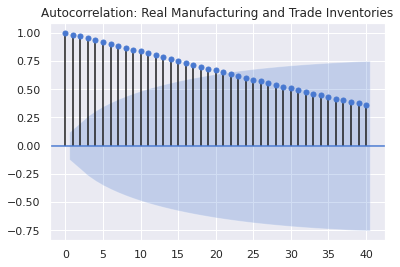

In [ ]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

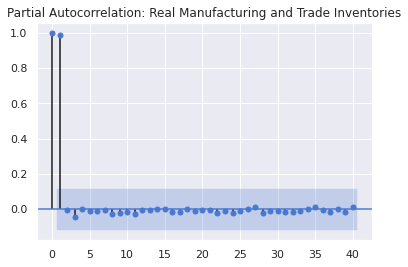

In [ ]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [ ]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.456 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Mon, 31 May 2021   AIC                           5348.037
Time:                        14:39:51   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks good from here! Now let's train & test the ARIMA(1,1,1) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [ ]:
len(df2)

264

In [ ]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [ ]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Mon, 31 May 2021   AIC                           4980.790
Time:                        14:04:10   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.875      2.378      0.018     561.663    5833.477
ar.L1.D.Inventories     0.9026      0.039     23.011      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107148.333, expected=2110158
predicted=2110526.201, expected=2118199
predicted=2113886.499, expected=2112427
predicted=2117230.941, expected=2112276
predicted=2120561.071, expected=2111835
predicted=2123878.284, expected=2109298
predicted=2127183.839, expected=2119618
predicted=2130478.871, expected=2127170
predicted=2133764.406, expected=2134172
predicted=2137041.37 , expected=2144639
predicted=2140310.597, expected=2143001
predicted=2143572.842, expected=2158115


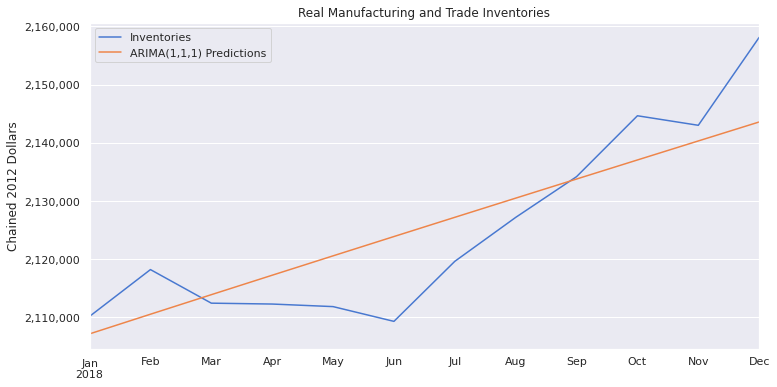

In [ ]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 60677819.87


In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 7789.596901


### Retrain the model on the full data, and forecast the future

In [ ]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

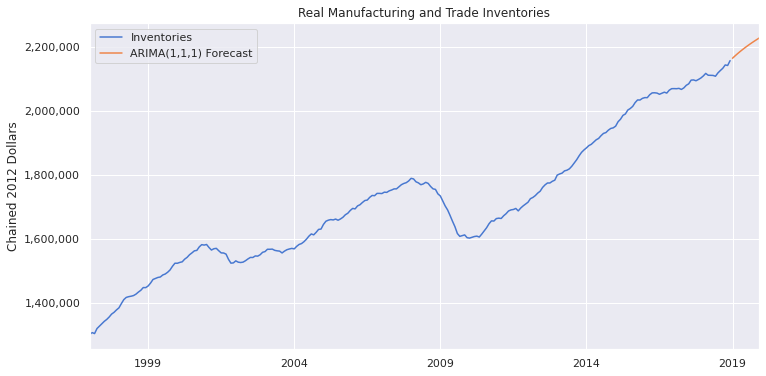

In [ ]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

## Perform standard imports and load datasets

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [ ]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [ ]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [ ]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


### Plot the source data

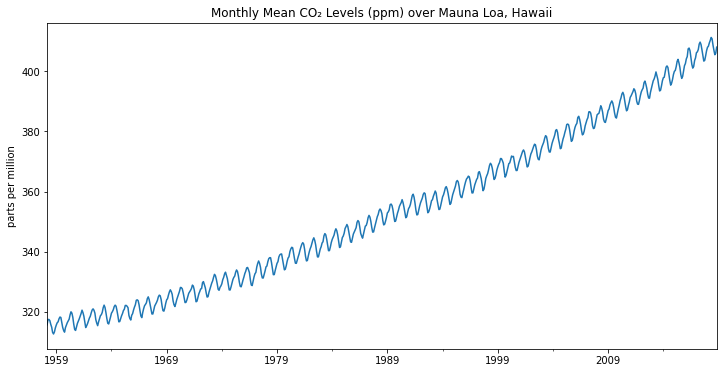

In [ ]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Run an ETS Decomposition

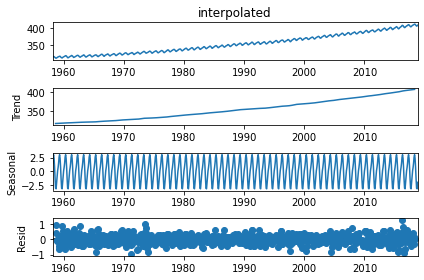

In [ ]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.258
Date:                            Mon, 31 May 2021   AIC                            424.515
Time:                                    14:13:16   BIC                            452.057
Sample:                                         0   HQIC                           435.142
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3528      0.100      3.520      0.000       0.156       0.549
ar.L2          0.0882      0.057      1.540      0.123      -0.024       0.200
ma.L1         -0.7078      0.098     -7.215      0.000      -0.900      -0.516
ar.S.L12       0.9996      0.000   2949.281      0.000       0.999       1.000
ma.S.L12      -0.8656      0.021    -40.420      0.000      -0.908      -0.824
sigma2         0.0958      0.005     20.426      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       43.66   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.32   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [ ]:
len(df)

729

In [ ]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [ ]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -201.188
Date:                            Mon, 31 May 2021   AIC                            414.377
Time:                                    14:13:20   BIC                            441.819
Sample:                                03-01-1958   HQIC                           424.973
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3541      0.036     -9.748      0.000      -0.425      -0.283
ma.L2         -0.0246      0.038     -0.650      0.516      -0.099       0.050
ma.L3         -0.0870      0.036     -2.406      0.016      -0.158      -0.016
ar.S.L12       0.9996      0.000   3083.366      0.000       0.999       1.000
ma.S.L12      -0.8660      0.023    -38.379      0.000      -0.910      -0.822
sigma2         0.0951      0.005     20.300      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.91   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6100843, expected=406.81
predicted=407.8253452, expected=407.96
predicted=408.579087 , expected=408.32
predicted=409.4841378, expected=409.41
predicted=411.0410272, expected=410.24
predicted=411.6441516, expected=411.24
predicted=410.8641553, expected=410.79
predicted=409.1740129, expected=408.71
predicted=407.0736894, expected=406.99
predicted=405.6234681, expected=405.51
predicted=405.893953 , expected=406.0
predicted=407.4276459, expected=408.02


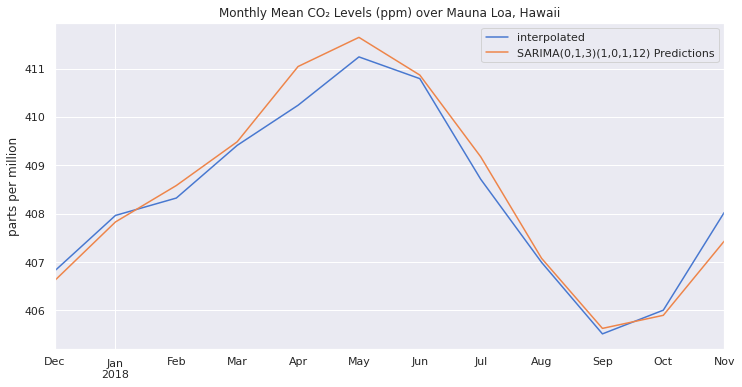

In [ ]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1282099285


In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3580641403


These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [ ]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

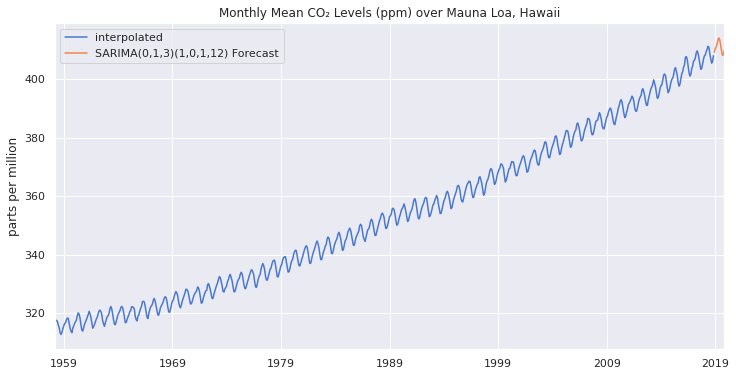

In [ ]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## *Appendex 01: pandas_datareader

In [ ]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2013, 1, 27)
gdp = web.DataReader('GDP', 'fred', start, end)
gdp.loc['2013-01-01']

GDP    16569.591
Name: 2013-01-01 00:00:00, dtype: float64

In [ ]:
inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start, end)
inflation.head(1)

,CPIAUCSL,CPILFESL
DATE,,
2010-01-01,217.488,220.633


In [ ]:
import pandas_datareader.wb as wb
wb=wb.WorldBankReader()

In [ ]:
# wb.get_countries()

# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

## Perform standard imports and load datasets

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/701-Time Series/Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
For this section we've built a Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [ ]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [ ]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [ ]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


### Plot the source data

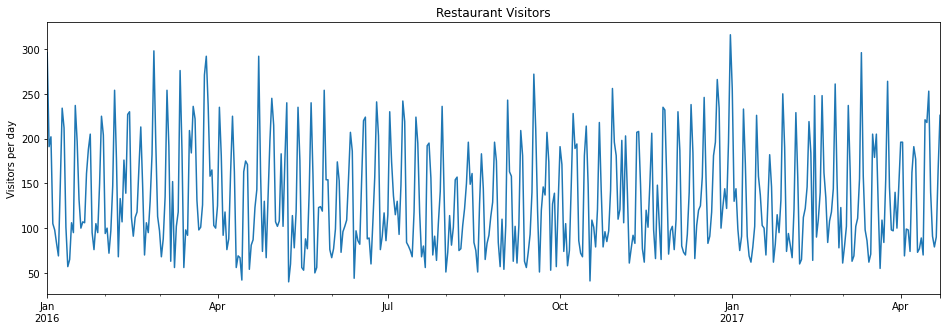

In [ ]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at holidays
Rather than prepare a separate plot, we can use matplotlib to shade holidays behind our restaurant data.

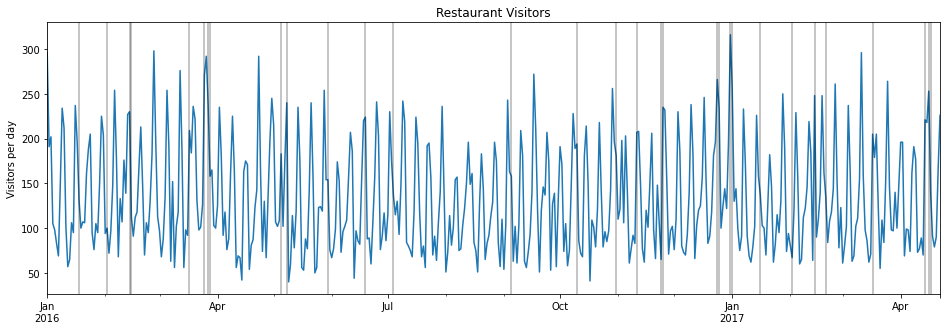

In [ ]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### Run an ETS Decomposition

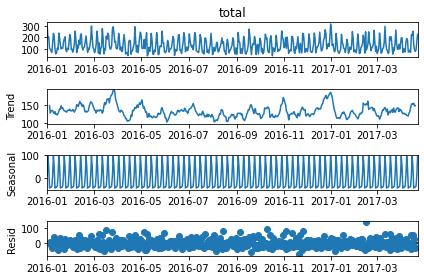

In [ ]:
result = seasonal_decompose(df1['total'])
result.plot();

## Test for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2383.845
Date:                   Mon, 31 May 2021   AIC                           4775.690
Time:                           15:04:11   BIC                           4792.369
Sample:                                0   HQIC                          4782.247
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7613      1.654      2.878      0.004       1.519       8.003
ar.S.L7        0.9624      0.013     75.584      0.000       0.937       0.987
ma.S.L7       -0.7581      0.048    -15.672      0.000      -0.853      -0.663
sigma2      1205.5235     70.693     17.053      0.000    1066.968    1344.079
===================================================================================
Ljung-Box (L1) (Q):                  16.20   Jarque-Bera (JB):                64.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.75
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [ ]:
len(df1)

478

In [ ]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### ACF, PACF

In [ ]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

In [ ]:
import statsmodels.api as sm
import seaborn as sns

plt.rcParams['figure.figsize'] = [14, 4]

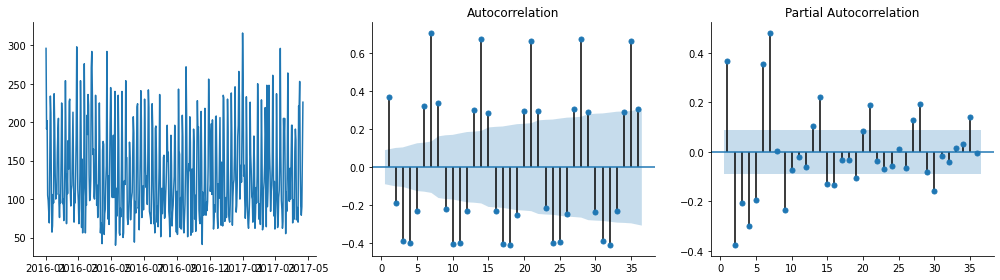

In [ ]:
plots(df1.total, lags=36);

### Fit a SARIMA(1,0,0)(2,0,0,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [ ]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Mon, 31 May 2021   AIC                           4457.403
Time:                                   15:17:28   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                29.23
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model2 = SARIMAX(train['total'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Mon, 31 May 2021   AIC                           4336.738
Time:                           15:17:33   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.56e-05   1.05e+04      0.000       1.000       1.000
ma.S.L7       -0.9384      0.024    -39.211      0.000      -0.985      -0.891
sigma2      1111.8035     58.742     18.927      0.000     996.672    1226.935
===================================================================================
Ljung-Box (L1) (Q):                  15.40   Jarque-Bera (JB):                83.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

In [ ]:
predictions2 = results2.predict(start=start, end=end, dynamic=False).rename('SARIMA(0,0,0)(1,0,1,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

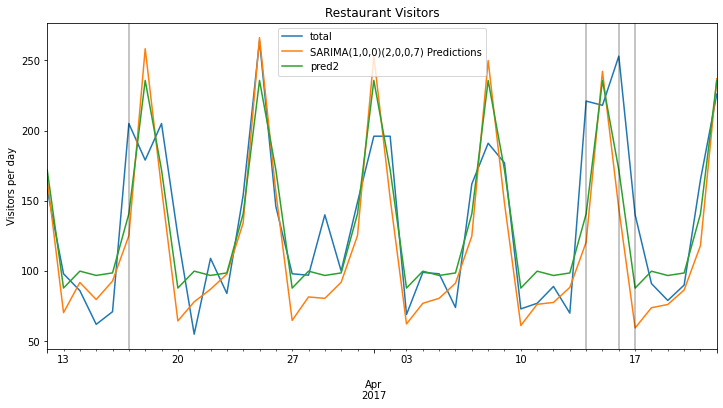

In [ ]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
predictions2.plot(legend=True,label='pred2')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Evaluate the Model

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647957
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315495


In [ ]:

error1 = mse(test['total'], predictions2)
error2 = rmse(test['total'], predictions2)

print(f'SARIMA(0,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(0,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMA(0,0,0)(1,0,1,7) MSE Error: 1018.360393
SARIMA(0,0,0)(1,0,1,7) RMSE Error: 31.91175948


## Now add the exog variable

In [ ]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Mon, 31 May 2021   AIC                           4326.963
Time:                                   15:21:10   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8878      4.241     15.773      0.000      58.576      75.199
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3920     73.301     15.244      0.000     973.725    1261.059
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.68   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

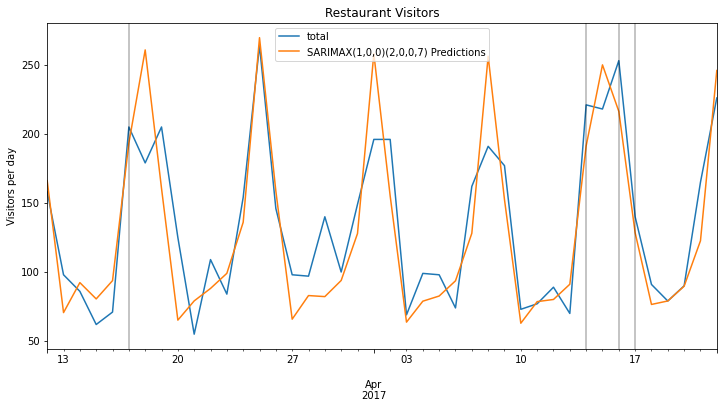

In [ ]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [ ]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1018.360393
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 31.91175948

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 950.6735446
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 30.83299441


### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [ ]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

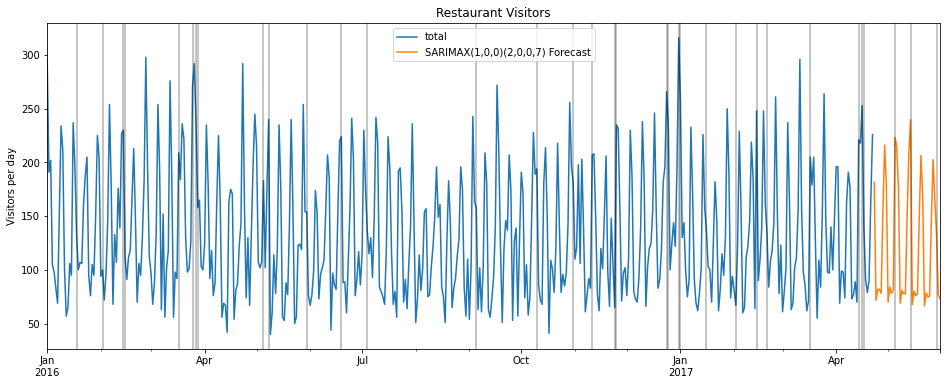

In [ ]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);